# Class Weight Calculator

This notebook allows you to load data in and calculate the necessary class weights (and other variables) needed to put in the config.yaml file.

In [18]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml

### Load in the data.

Here we have the data as a CSV file, but you may need to change that for your data
formatting.

In [19]:
def get_counts(file, allowed_types):
    """
    Generates counts of objects using the data (here a CSV file) in ./data
    """
    df = pd.read_csv(file)
    print(df.head())
    counts = df[df['spec_class'].isin(allowed_types)]['spec_class'].value_counts()
    total_sum = counts.sum()
    return counts, total_sum

In [20]:
from superphot_plus.config import SuperphotConfig

vertices = ['SLSN-I', 
            'SLSN-II', 
            'SN', 
            'SN II', 
            'SN II-pec', 
            'SN IIb', 
            'SN IIn', 
            'SN Ia', 
            'SN Ia-91T-like',
            'SN Ia-91bg-like', 
            'SN Ia-CSM',
            'SN Ia-SC', 
            'SN Ia-pec',
            'SN Iax[02cx-like]', 
            'SN Ib', 
            'SN Ib-pec', 
            'SN Ib/c', 
            'SN Ibn', 
            'SN Ic',
            'SN Ic-BL', 
            #'SN Ic-Ca-rich', 
            #'SN Ic-pec', 
            #'SN Icn', 
            'TDE', 
            'SN-like', 
            'CC', 
            'SN II-gen', 
            'SN-gen', 
            'SN Ia-gen', 
            'SN II-like', 
            'SN Ib/c-gen', 
            'SN Ic-gen', 
            'SN Ib-gen', 
            'SN IIn-like',
            #'SN IIL',
            'SN IIP']

config = SuperphotConfig.from_file("../config.yaml")
counts, total = get_counts(f'{config.data_dir}/quality_cut_tns_data.csv', vertices)
counts, total

['SLSN-I', 'SLSN-II', 'SN', 'SN II', 'SN II-pec', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-SC', 'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c', 'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Ic-pec', 'SN Icn', 'TDE']
         id          ra        dec                     internal_names  \
0     2019J  150.944878   6.773457  PS18crs, ATLAS19cay, ZTF19aacxrab   
1  2019aafe  349.068683  48.428444                       ZTF19abzfxel   
2  2019aamp  219.455292  20.304611                       ZTF19aantokv   
3  2019aanx  112.499958  13.095333                       ZTF19ackiwff   
4  2019aaot    3.069526  -5.727405                       ZTF19aazdroc   

  spec_class  redshift  
0     SLSN-I     0.120  
1     SN IIn     0.074  
2     SLSN-I     0.404  
3    SLSN-II     0.403  
4        AGN     0.283  


(spec_class
 SN Ia                5479
 SN II                1222
 SN IIn                222
 SN Ia-91T-like        196
 SN Ic                 143
 SN Ib                 129
 SLSN-I                104
 SN IIb                103
 SN IIP                 90
 TDE                    73
 SN Ic-BL               68
 SLSN-II                51
 SN Ia-pec              38
 SN Ia-91bg-like        37
 SN Ibn                 27
 SN                     26
 SN Iax[02cx-like]      24
 SN Ib/c                22
 SN Ia-CSM              20
 SN Ia-SC               10
 SN II-pec               7
 SN Ib-pec               5
 Name: count, dtype: int64,
 8096)

### Generate the tree.
This is a duplicate/technically unnecessary step as defining the taxonomy does it, 
but for simplicity's sake, we duplicate this here.

In [21]:
G = nx.DiGraph()

G.add_edge('SN-like', 'SN-gen')
G.add_edge('SN-like', 'TDE')

G.add_edge('SN-gen', 'SN')
G.add_edge('SN-gen', 'SN Ia-gen')
G.add_edge('SN Ia-gen', 'SN Ia')
G.add_edge('SN Ia-gen', 'SN Ia-91T-like')
G.add_edge('SN Ia-gen', 'SN Ia-91bg-like')
G.add_edge('SN Ia-gen', 'SN Ia-CSM')
G.add_edge('SN Ia-gen', 'SN Ia-SC')
G.add_edge('SN Ia-gen', 'SN Ia-pec')
G.add_edge('SN Ia-gen', 'SN Iax[02cx-like]')


G.add_edge('SN-gen', 'CC')

G.add_edge('CC', 'SN II-gen')

G.add_edge('CC', 'SN Ib/c-gen')

G.add_edge('SN Ib/c-gen', 'SN Ib/c')

G.add_edge('SN Ib/c-gen', 'SN Ib-gen')
G.add_edge('SN Ib/c-gen', 'SN Ic-gen')

G.add_edge('SN Ib-gen', 'SN Ib-pec')
G.add_edge('SN Ib-gen', 'SN Ibn')
G.add_edge('SN Ib-gen', 'SN Ib')

G.add_edge('SN Ic-gen', 'SN Ic-BL')
# G.add_edge('SN Ic-gen', 'SN Ic-Ca-rich')
# G.add_edge('SN Ic-gen', 'SN Ic-pec')
# G.add_edge('SN Ic-gen', 'SN Icn')
G.add_edge('SN Ic-gen', 'SN Ic')


G.add_edge('SN II-gen', 'SN IIn-like')
G.add_edge('SN IIn-like', 'SLSN-II')
G.add_edge('SN IIn-like', 'SN IIn')

G.add_edge('SN II-gen', 'SN II-like')
G.add_edge('SN II-like', 'SN II-pec')
G.add_edge('SN II-like', 'SN IIb')
#G.add_edge('SN II-like', 'SN IIL')
G.add_edge('SN II-like', 'SN IIP')
G.add_edge('SN II-like', 'SN II')

G.add_edge('CC', 'SLSN-I')

Sanity check for our tree construction.

In [22]:
"""
Hierarchy Position Encoder.
Taken from stackoverflow: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
(Used in hxe-for-tda)
"""

def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

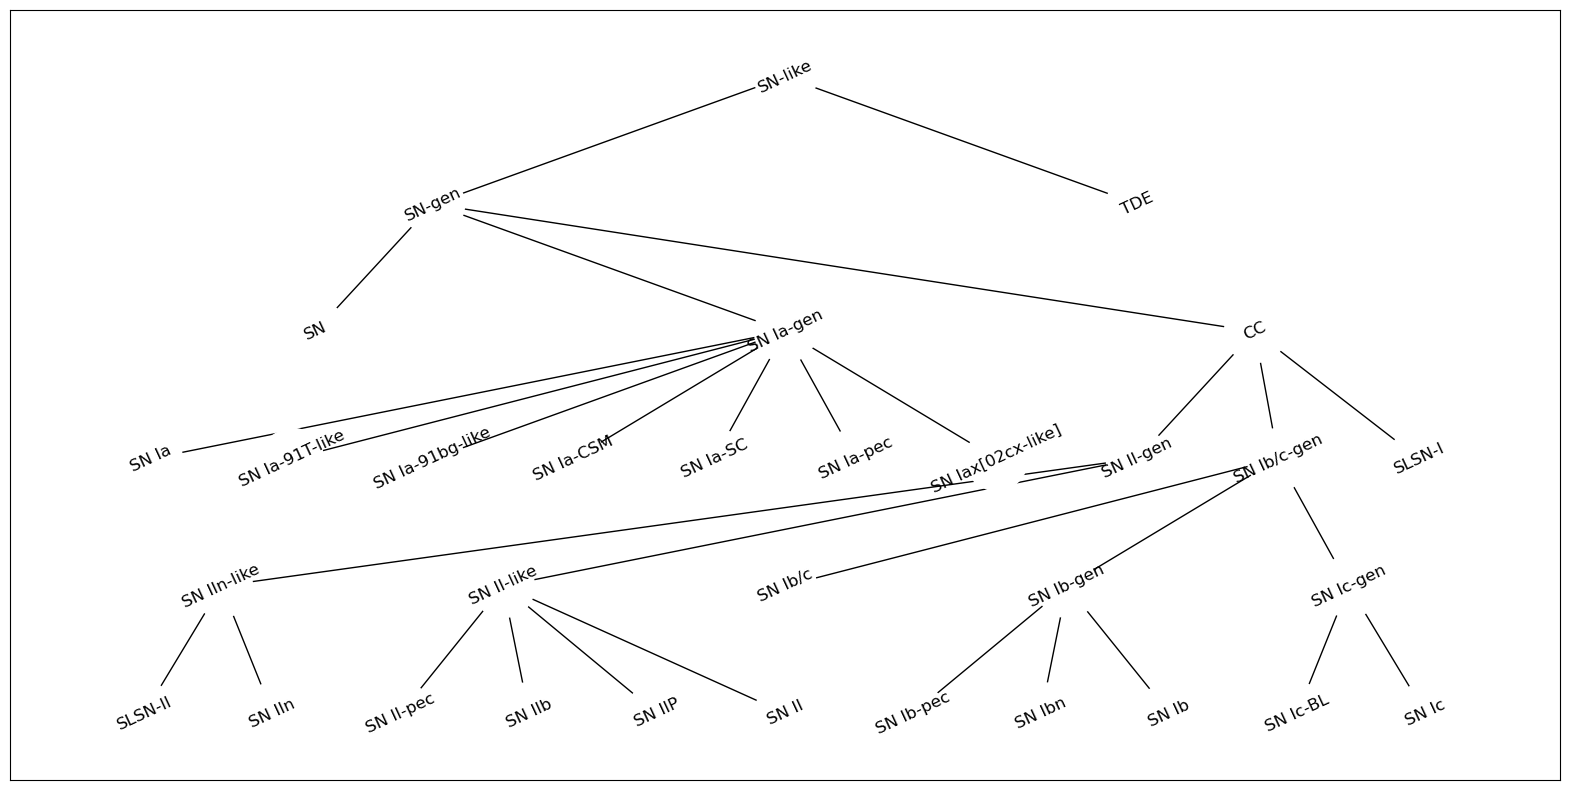

In [23]:
# Encode positions of graph - purely for drawing purposes
pos = hierarchy_pos(G, 'SN-like')
#print(pos)

fig = plt.figure(1, figsize=(20,10))
nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)

#Uncomment if need to rotate the labels for a more advanced label system.
for _, t in text.items():
     t.set_rotation(25) 

plt.show()

In [24]:
for edge in G.edges.data():
    if edge[0] not in vertices:
        print(edge[0])
    elif edge[1] not in vertices:
        print(edge[1])

### Find the shortest paths between root and all other nodes.

In [25]:
def short_paths(graph, vertices, root):
    """
    Builds a list of shortest paths from root to node from our tree.
    """
    paths = []
    for node in vertices:
        paths.append(nx.shortest_path(graph, root, node))
    return paths

In [26]:
all_paths = short_paths(G, vertices, 'SN-like')
all_paths

[['SN-like', 'SN-gen', 'CC', 'SLSN-I'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN IIn-like', 'SLSN-II'],
 ['SN-like', 'SN-gen', 'SN'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN II'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN II-pec'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN II-like', 'SN IIb'],
 ['SN-like', 'SN-gen', 'CC', 'SN II-gen', 'SN IIn-like', 'SN IIn'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-91T-like'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-91bg-like'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-CSM'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-SC'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Ia-pec'],
 ['SN-like', 'SN-gen', 'SN Ia-gen', 'SN Iax[02cx-like]'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib-gen', 'SN Ib'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib-gen', 'SN Ib-pec'],
 ['SN-like', 'SN-gen', 'CC', 'SN Ib/c-gen', 'SN Ib/c'],
 ['SN-like', 'SN-gen', 'CC', 'SN

### Function to calculate the class weights.

Copied from hxetda.py from https://github.com/VTDA-Group/hxe-for-tda/blob/main/hxetda/hxetda.py

In [27]:
def calc_class_weights(counts, all_paths):
    """Generates the class weights based on the data.
    
    Calculates W(c^(h)) = N_all / (N_{labels} * N_c) where:
    N_all = total number of events in the dataset
    N_labels = the number of unique classes
    N_c = the number of events of class c

    Parameters
    ----------
    counts : panda dataframe
        A pandas dataframe of labels and counts from the CSV file.
    
    all_paths : str list list
        List of all the shortest paths between root and and a given node
        in the tree. This is found using Dijkstra's.

    Returns
    -------
    class_weight_dict : str -> float
        Contains weights of each label in the dataset (due to
        unbalanced data).
    """

    # Get the names and counts of the unique classes within the data set
    names_list = counts.index.tolist()
    counts_list = counts.values.tolist()

    # Generates class weight dictionary
    class_weight_dict = {}

    # We need to include everything in the hierarchy under a given label in the count of class c
    for label in names_list:
        count_for_ulabel = 0

        for label2 in names_list:
            # this index in vertices corresponds to the path that terminates in label2 in all_paths
            g_ind = vertices.index(label2)
            if label in all_paths[g_ind]:
                count_for_ulabel += counts_list[names_list.index(label2)]
        
        class_weight_dict[label] = [(sum(counts_list)/(len(names_list) * count_for_ulabel)), count_for_ulabel]
    return class_weight_dict

In [31]:
class_weights = calc_class_weights(counts, all_paths)
class_weights

{'SN Ia': [0.06716554115714546, 5479],
 'SN II': [0.3011456628477905, 1222],
 'SN IIn': [1.6576576576576576, 222],
 'SN Ia-91T-like': [1.8775510204081634, 196],
 'SN Ic': [2.5734265734265733, 143],
 'SN Ib': [2.852713178294574, 129],
 'SLSN-I': [3.5384615384615383, 104],
 'SN IIb': [3.5728155339805827, 103],
 'SN IIP': [4.088888888888889, 90],
 'TDE': [5.041095890410959, 73],
 'SN Ic-BL': [5.411764705882353, 68],
 'SLSN-II': [7.215686274509804, 51],
 'SN Ia-pec': [9.68421052631579, 38],
 'SN Ia-91bg-like': [9.945945945945946, 37],
 'SN Ibn': [13.62962962962963, 27],
 'SN': [14.153846153846153, 26],
 'SN Iax[02cx-like]': [15.333333333333334, 24],
 'SN Ib/c': [16.727272727272727, 22],
 'SN Ia-CSM': [18.4, 20],
 'SN Ia-SC': [36.8, 10],
 'SN II-pec': [52.57142857142857, 7],
 'SN Ib-pec': [73.6, 5]}

Sanity check to make sure weights equally weight each class (without double counting).
Note, we assume that all data labels/classes should be leaves within the taxonomy.

In [32]:
# count_dict = {}
# for i in class_weights.keys():
names_list = counts.index.tolist()
counts_list = counts.values.tolist()
#     count_for_ulabel = 0
#     for label in names_list:
#         g_ind = vertices.index(label)
#         if i in all_paths[g_ind]:
#             count_for_ulabel += counts_list[names_list.index(label)]
        
#     print(i, ":", class_weights[i]*count_for_ulabel)
count_dict = {}
for i in class_weights.keys():    
    print(i, ":", class_weights[i][0]*counts_list[names_list.index(i)])


SN Ia : 367.99999999999994
SN II : 368.0
SN IIn : 368.0
SN Ia-91T-like : 368.0
SN Ic : 368.0
SN Ib : 368.0
SLSN-I : 368.0
SN IIb : 368.0
SN IIP : 368.0
TDE : 368.0
SN Ic-BL : 368.0
SLSN-II : 368.0
SN Ia-pec : 368.0
SN Ia-91bg-like : 368.0
SN Ibn : 368.0
SN : 368.0
SN Iax[02cx-like] : 368.0
SN Ib/c : 368.0
SN Ia-CSM : 368.0
SN Ia-SC : 368.0
SN II-pec : 368.0
SN Ib-pec : 368.0


### Translate into Copy-able Format for Config.yaml

This writes to class_Weight_config_copy.yaml in this folder. You need to copy
the contents of this file to the correct config.yaml file for use.

In [33]:
def reformat(val):
    
    with open('class_weight_config_copy.yaml', 'w') as f:
        yaml.dump(val, f)

In [34]:
class_w = {'class_weights' : class_weights}
reformat(class_w)

Sanity check to make sure that the dictionary is written to the config file format
correctly.

In [35]:
import yaml

# Open and load the YAML file
with open('class_weight_config_copy.yaml', 'r') as f:
    data = yaml.safe_load(f)

# Now `data` is a Python dictionary
data

{'class_weights': {'SLSN-I': [3.5384615384615383, 104],
  'SLSN-II': [7.215686274509804, 51],
  'SN': [14.153846153846153, 26],
  'SN II': [0.3011456628477905, 1222],
  'SN II-pec': [52.57142857142857, 7],
  'SN IIP': [4.088888888888889, 90],
  'SN IIb': [3.5728155339805827, 103],
  'SN IIn': [1.6576576576576576, 222],
  'SN Ia': [0.06716554115714546, 5479],
  'SN Ia-91T-like': [1.8775510204081634, 196],
  'SN Ia-91bg-like': [9.945945945945946, 37],
  'SN Ia-CSM': [18.4, 20],
  'SN Ia-SC': [36.8, 10],
  'SN Ia-pec': [9.68421052631579, 38],
  'SN Iax[02cx-like]': [15.333333333333334, 24],
  'SN Ib': [2.852713178294574, 129],
  'SN Ib-pec': [73.6, 5],
  'SN Ib/c': [16.727272727272727, 22],
  'SN Ibn': [13.62962962962963, 27],
  'SN Ic': [2.5734265734265733, 143],
  'SN Ic-BL': [5.411764705882353, 68],
  'TDE': [5.041095890410959, 73]}}

### Some other translations into yaml format for config file. 
Use as needed.

In [36]:
# vertices = ['SLSN-I', 
#             'SLSN-II', 
#             'SN', 
#             'SN II', 
#             'SN II-pec', 
#             'SN IIb', 
#             'SN IIn', 
#             'SN Ia', 
#             'SN Ia-91T',
#             'SN Ia-91bg-like', 
#             'SN Ia-CSM',
#             'SN Ia-SC', 
#             'SN Ia-pec',
#             'SN Iax', 
#             'SN Ib', 
#             'SN Ib-pec', 
#             'SN Ib/c', 
#             'SN Ibn', 
#             'SN Ic',
#             'SN Ic-BL', 
#             'SN Ic-Ca-rich', 
#             'SN Ic-pec', 
#             'SN Icn', 
#             'TDE', 
#             'SN-like', 
#             'CC', 
#             'SN II-gen', 
#             'SN-gen', 
#             'SN Ia-gen', 
#             'SN II-like', 
#             'SN Ib/c-gen', 
#             'SN Ic-gen', 
#             'SN Ib-gen', 
#             'SN IIn-like',
#             'SN IIL',
#             'SN IIP']
edges = []
for (u, v, c) in G.edges.data():
    edges.append([u, v])

graph_dict = {
    "graph" : {
        "root" : "SN-like",
        "height" : 4,
        "vertices" : vertices,
        "edges" : edges,
        "ignored_leaves": ['SN Ia-91T', 'SN Iax']
    }}

In [37]:
reformat(graph_dict)